
<h1 style="text-align: center">Object Detection</h1>
In this project a custom model is trained to perform object detection on the Fashion MNIST dataset. Object detection is a technique in computer vision for locating instances of objects in images/videos. The model is trained on the Fashion MNIST dataset - an image dataset of Zalando's clothing articles. The dataset includes 70,000 samples of 10 clothing articles. While Fashion MNIST is typically used as a benchmark to validate image classification algorithms, in this project the dataset is transformed to be fit for object detection. The performance of the custom built model will then be compared with that of InceptionV3. InceptionV3 is an image classification algorithm trained on the ImageNet dataset. It is chosen as the benchmark model for this project because it has shown one of the <a href = 'https://paperswithcode.com/sota/image-classification-on-fashion-mnist'>best results</a> in classification of the Fashion MNIST dataset reaching up to 94% accuracy. The model will be adapted for object detection via transfer learning. 



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPooling2D, AveragePooling2D

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False

<h3 style="text-align: center"> Loading the Data</h3>
Fashion MNIST dataset is loaded from Tensorflow Hub. As mentioned, the dataset has 70,000 sample images of 10 articles: T-shirt/Top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Boots. Each image is black and white and has a (28, 28) shape. 

In [ ]:
classes = dict(zip(range(10), ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boots']))
shape   = (28, 28)

In [ ]:
train, test = tfds.load('fashion_mnist', split = ['train','test'], as_supervised = True, try_gcs = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incompleteOTG8LF/fashion_mnist-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incompleteOTG8LF/fashion_mnist-test.tfrecord*...:   0%|   …

Dataset fashion_mnist downloaded and prepared to ~/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


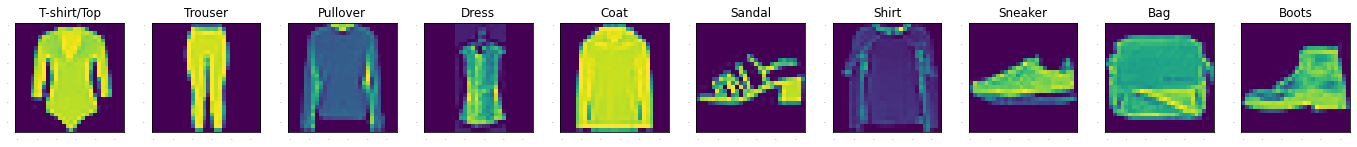

In [ ]:
fig, ax = plt.subplots(ncols = 10, figsize = (24, 2))
l = list(range(10))
for im, article in train.take(100):
    if article in l:
        ax[article].imshow(im[:,:, 0])
        ax[article].set_title(classes[article.numpy()])
        l.remove(article)
    if len(l) == 0:
        break

<h3 style="text-align: center">Data Preprocessing</h3>

The data is now synthesized to adapt it for the object detection problem. Each (28, 28) image is randomly placed onto a (150, 150) black canva. (150, 150) is the minimum image dimension acceptable by InceptionV3. The images are arranged onto a larger canva by zero-padding the original image with $i$ random rows and $j$ random columns of pixels. $i, j$ are randomly generated values that are $(28 + i) \leq 150$ and $(28 + j) \leq 150$. The bounding box is set to be the frame of the original (28, 28) image as the articles are tightly framed in the first place. With the height and width being fixed the bounding box for each image will be defined by a pair of values $(x_{min}, y_{min})$ - coordinates of the top left corner.

Once the data is synthesized the train-test datasets are pre-processed: they are turned into infinite iterators, shuffled, and split into batches.

In [ ]:
def add_padding(x, label):
    i = tf.random.uniform((), 0 , 123, dtype = tf.int32)
    j = tf.random.uniform((), 0 , 123, dtype = tf.int32)
    x = tf.cast(tf.image.pad_to_bounding_box(x, i, j, 150, 150), tf.float32)/255.0
    return x, (label, tf.cast([j, i], tf.float32)/150)

def prepare_ds(X, _set = 'train'):
    if _set == 'train':
        X = X.shuffle(buffer_size = 4096, reshuffle_each_iteration = True)
        X = X.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    X = X.map(add_padding)
    X = X.batch(batch_size = 64, drop_remainder = True)
    X = X.repeat()
    return X

train = prepare_ds(train)
test  = prepare_ds(test, 'test') 

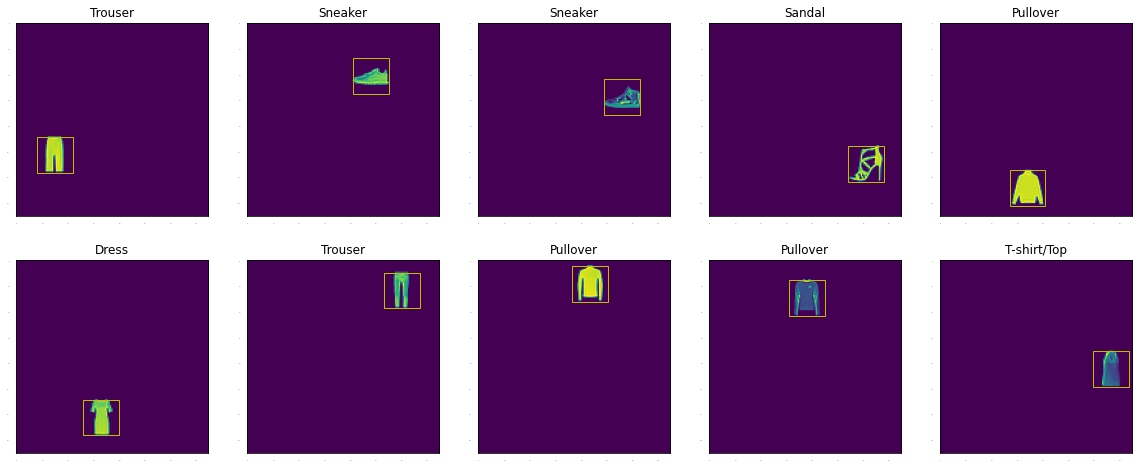

In [ ]:
def sample_images(X):
    from matplotlib.patches import Rectangle
    for im, (label, box) in X.take(1):
        fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 8))
        for i in range(10):
            j = np.random.choice(im.shape[0])
            ax[int(i%2), int(i%5)].imshow(im[j][:, :, 0])
            ax[int(i%2), int(i%5)].set_title(classes[label[j].numpy()])
            ax[int(i%2), int(i%5)].add_patch(Rectangle(box[j]*150, 28, 28, fill=False, color = 'y'))
        break

sample_images(train)

<h3 style="text-align: center">Custom Model Definition</h3>

The model network will consist of a series of convolutional and pooling layers for feature extraction, followed by dense layers for classification and bounding box identification. The loss functions employed are Sparse Categorical Crossentropy for multi-class classification of articles since labels were not one-hot encoded and Mean Absolute Error for evaluation of the bounding box predictions. Stochastic Gradient Descent is used for model optimization as it has been shown to yield better generalization performance than the standard choice amongst adaptive models - Adam.

In [ ]:
# Feature Extraction
inputs = Input(shape = (150, 150, 1))
x = Conv2D(16, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = AveragePooling2D((2, 2))(x)

# Dense Layers
x = Flatten()(x)
x = Dense(64, activation = 'relu')(x)
x = Dense(32, activation = 'relu')(x)

# Classification
out_class = Dense(10, activation = 'softmax', name = 'classification')(x)

# Bounding Box identification
out_bbox = Dense(2, name = 'bounding_box')(x)

model = tf.keras.Model(inputs = inputs, outputs = [out_class, out_bbox])
model.compile('adam', loss = {'classification': 'sparse_categorical_crossentropy','bounding_box':'mse'},
                    metrics = {'classification' : 'accuracy', 'bounding_box' : 'mae'})

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 148, 148, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 74, 74, 16)  0           ['conv2d_3[0][0]']               
                                                                                            

In [ ]:
history = model.fit(train, epochs = 16, steps_per_epoch = 60000//64, 
          validation_steps = 10000//64, validation_data = test)

for test_im, (test_label, test_box) in test:
    break
y_pr = model.predict(test_im)

Epoch 1/16
937/937 [==============================] - 27s 29ms/step - loss: 0.8104 - classification_loss: 0.8021 - bounding_box_loss: 0.0083 - classification_accuracy: 0.6849 - bounding_box_mae: 0.0709 - val_loss: 0.7385 - val_classification_loss: 0.7321 - val_bounding_box_loss: 0.0064 - val_classification_accuracy: 0.7149 - val_bounding_box_mae: 0.0621
Epoch 2/16
937/937 [==============================] - 25s 27ms/step - loss: 0.6998 - classification_loss: 0.6935 - bounding_box_loss: 0.0063 - classification_accuracy: 0.7312 - bounding_box_mae: 0.0618 - val_loss: 0.6463 - val_classification_loss: 0.6414 - val_bounding_box_loss: 0.0049 - val_classification_accuracy: 0.7561 - val_bounding_box_mae: 0.0533
Epoch 3/16
937/937 [==============================] - 26s 28ms/step - loss: 0.6204 - classification_loss: 0.6154 - bounding_box_loss: 0.0050 - classification_accuracy: 0.7652 - bounding_box_mae: 0.0549 - val_loss: 0.6027 - val_classification_loss: 0.5983 - val_bounding_box_loss: 0.0044 -

<h3 style="text-align: center">Transfer Learning with InceptionV3</h3>
A pre-trained InceptionV3 model available in Keras is loaded and adapted for object detection. The top layer of the InceptionV3 model responsible for object classification is excluded, leaving only the CNN. The 3D output of this CNN is reduced to a single dimension using Global Average Pooling rendering it compatible for the following dense detection network. The detection network includes two heads each consisting of one Dense layer: one for classification and other for bounding box detection. 

In [ ]:
inception = tf.keras.applications.inception_v3.InceptionV3(include_top=False, input_shape = (150, 150, 3), pooling='avg')
inception.trainable = False
inception.summary()

In [ ]:
# To delete
def inception_prep(X, label):
    X = tf.concat([X, X, X], axis = 3)
    return X, label
train2 = train.map(inception_prep)
test2 = test.map(inception_prep)

# for i in test2.take(1):
#     print(i[0].shape)
# sample_images(test2)

In [ ]:
inputs = tf.keras.Input(shape=(150, 150, 3))
x                    = inception(inputs, training=False)
# x                    = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation = 'relu')(x)
# x = Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dropout(.2)(x) 
inception_classifier = Dense(10, activation = 'softmax', name = 'classifier')(x)
inception_box        = Dense(2, name = 'bounding_box')(x)
inception_model      = tf.keras.Model(inputs, outputs = [inception_classifier, inception_box])

inception_model.compile('adam', loss = {'classifier': 'sparse_categorical_crossentropy','bounding_box':'mse'},
               metrics = {'classifier' : 'accuracy', 'bounding_box' : 'mae'})

inception_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_v3 (Functional)      (None, 2048)         21802784    ['input_9[0][0]']                
                                                                                                  
 dense_10 (Dense)               (None, 512)          1049088     ['inception_v3[5][0]']           
                                                                                                  
 dropout_1 (Dropout)            (None, 512)          0           ['dense_10[0][0]']         

In [ ]:
inception_history = inception_model.fit(train2, epochs = 10, steps_per_epoch = 60000//64, 
                                        validation_steps = 10000//64, validation_data = test2)

Epoch 1/10
937/937 [==============================] - 76s 77ms/step - loss: 1.0363 - classifier_loss: 1.0039 - bounding_box_loss: 0.0324 - classifier_accuracy: 0.6452 - bounding_box_mae: 0.1153 - val_loss: 0.8080 - val_classifier_loss: 0.8012 - val_bounding_box_loss: 0.0068 - val_classifier_accuracy: 0.7069 - val_bounding_box_mae: 0.0637
Epoch 2/10
937/937 [==============================] - 70s 75ms/step - loss: 0.7834 - classifier_loss: 0.7739 - bounding_box_loss: 0.0094 - classifier_accuracy: 0.7188 - bounding_box_mae: 0.0757 - val_loss: 0.7482 - val_classifier_loss: 0.7436 - val_bounding_box_loss: 0.0046 - val_classifier_accuracy: 0.7278 - val_bounding_box_mae: 0.0525
Epoch 3/10
937/937 [==============================] - 70s 74ms/step - loss: 0.7326 - classifier_loss: 0.7248 - bounding_box_loss: 0.0078 - classifier_accuracy: 0.7329 - bounding_box_mae: 0.0688 - val_loss: 0.7070 - val_classifier_loss: 0.7026 - val_bounding_box_loss: 0.0044 - val_classifier_accuracy: 0.7456 - val_bound

<h3 style='text-align:center;'> Performance </h3>
Judging by the loss and accuracy plots the custom model is more fit for object detection on the Fashion MNIST dataset. It has an 88% classification accuracy and 0.03 mean absolute error in bounding box prediction, compared to 76% classification accuracy and 0.06 mae for InceptionV3. InceptionV3 offers better starting performance since its initial weights of the encoding network are pre-trained, unlike in the case of the custom model which starts from random weights.



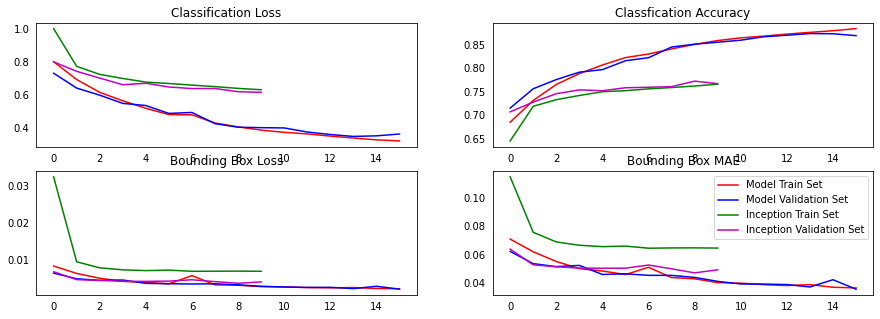

In [ ]:
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (15, 5))
model_epochs = np.arange(len(history.history['loss']))
incep_epochs = np.arange(len(inception_history.history['loss']))

ax[0, 0].plot(model_epochs, history.history['classification_loss'], 'r')
ax[0, 0].plot(model_epochs, history.history['val_classification_loss'], 'b')
ax[0, 0].plot(incep_epochs, inception_history.history['classifier_loss'], 'g')
ax[0, 0].plot(incep_epochs, inception_history.history['val_classifier_loss'], 'm')
ax[0, 0].set_title("Classification Loss")
ax[0, 1].plot(model_epochs, history.history['classification_accuracy'], 'r')
ax[0, 1].plot(model_epochs, history.history['val_classification_accuracy'], 'b')
ax[0, 1].plot(incep_epochs, inception_history.history['classifier_accuracy'], 'g')
ax[0, 1].plot(incep_epochs, inception_history.history['val_classifier_accuracy'], 'm')
ax[0, 1].set_title("Classfication Accuracy")

ax[1, 0].plot(model_epochs, history.history['bounding_box_loss'], 'r')
ax[1, 0].plot(model_epochs, history.history['val_bounding_box_loss'], 'b')
ax[1, 0].plot(incep_epochs, inception_history.history['bounding_box_loss'], 'g')
ax[1, 0].plot(incep_epochs, inception_history.history['val_bounding_box_loss'], 'm')
ax[1, 0].set_title("Bounding Box Loss")

ax[1, 1].plot(model_epochs, history.history['bounding_box_mae'], 'r', label = 'Model Train Set')
ax[1, 1].plot(model_epochs, history.history['val_bounding_box_mae'], 'b', label = 'Model Validation Set')
ax[1, 1].plot(incep_epochs, inception_history.history['bounding_box_mae'], 'g', label = 'Inception Train Set')
ax[1, 1].plot(incep_epochs, inception_history.history['val_bounding_box_mae'], 'm', label = 'Inception Validation Set')
ax[1, 1].set_title("Bounding Box MAE")
ax[1, 1].legend()

ax[0, 0].tick_params(axis='both', which='major', labelsize=10)      
ax[0, 1].tick_params(axis='both', which='major', labelsize=10)      
ax[1, 0].tick_params(axis='both', which='major', labelsize=10)      
ax[1, 1].tick_params(axis='both', which='major', labelsize=10)      


<h3>Predictions</h3>

Now to visually evaluate the performance of the two models their predictions on the test set will be plotted. In addition the intersection over uninon will be computed metric to evaluate the accuracy of the predicted bounding boxes. 

In [ ]:
for sample in test.take(1):
    print(sample[0].shape)
    print(tf.concat([tf.expand_dims(tf.concat([i for _ in range(3)], axis = 2), axis = 0) for i in sample[0]], axis = 0).shape)
    break

model_pred = model.predict(sample[0])
incep_pred = inception_model.predict(tf.concat([tf.expand_dims(tf.concat([tf.image.resize(i, (150, 150)) for _ in range(3)], axis = 2), axis = 0) for i in sample[0]], axis = 0))

(64, 150, 150, 1)
(64, 150, 150, 3)
2/2 [==============================] - 2s 21ms/step


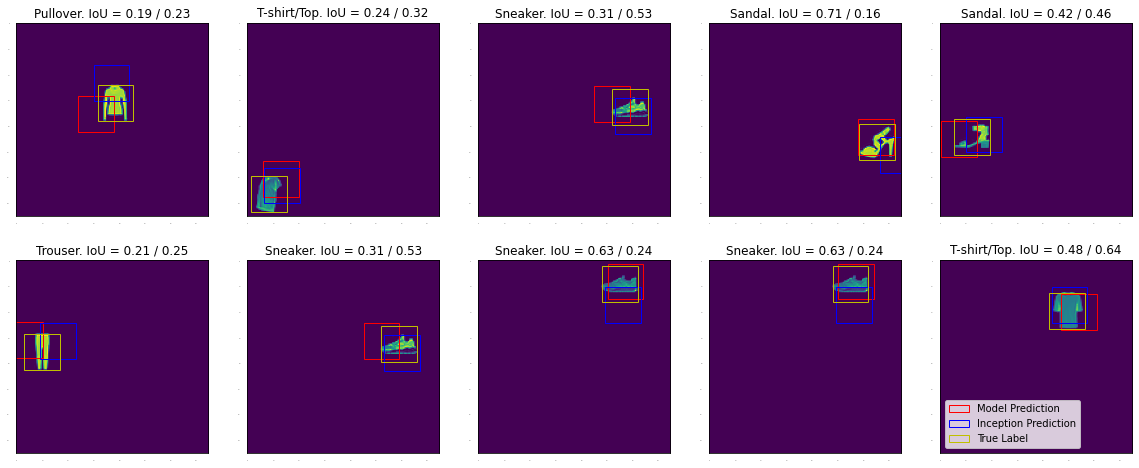

In [ ]:

def iou(y, p):
    y = y.numpy()
    x = np.sort([y[0], p[0]]) * 150
    y = np.sort([y[1], p[1]]) * 150
    piy = (x[0] + 28 - x[1])*(y[0] + 28 - y[1])
    return piy/(2*28**2 - piy)

def sample_pred(im, model_pred, incep_pred):
    from matplotlib.patches import Rectangle
    fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 8))
    (label, box) = model_pred
    (label2, box2) = incep_pred
    label = np.argmax(label, axis = 1)
    label2 = np.argmax(label2, axis = 1)
    for i in range(10):
        j = np.random.choice(im[0].shape[0])

        model_iou = iou(im[1][1][j], box[j])
        incep_iou = iou(im[1][1][j], box2[j])

        ax[int(i%2), int(i%5)].imshow(im[0][j][:,:,0])
        ax[int(i%2), int(i%5)].add_patch(Rectangle(box[j]*150, 28, 28, fill=False, color = 'r', label = 'Model Prediction'))
        ax[int(i%2), int(i%5)].add_patch(Rectangle(box2[j]*150, 28, 28, fill=False, color = 'b', label = 'Inception Prediction'))
        ax[int(i%2), int(i%5)].add_patch(Rectangle(im[1][1][j]*150, 28, 28, fill=False, color = 'y', label = 'True Label'))
        ax[int(i%2), int(i%5)].set_title(f"{classes[label[j]]}. IoU = {model_iou:0.2f} / {incep_iou:0.2f}")
    ax[1, 4].legend()

sample_pred(sample, model_pred, incep_pred)